* Andrej Karpathy micrograd: https://github.com/karpathy/micrograd  
* Andrej Karpathy building micrograd video: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&ab_channel=AndrejKarpathy

# Derivatives

In [1]:
def f(x):
    return (3 * (x ** 2)) - (4 * x) + 5

In [2]:
f(3.0)

20.0

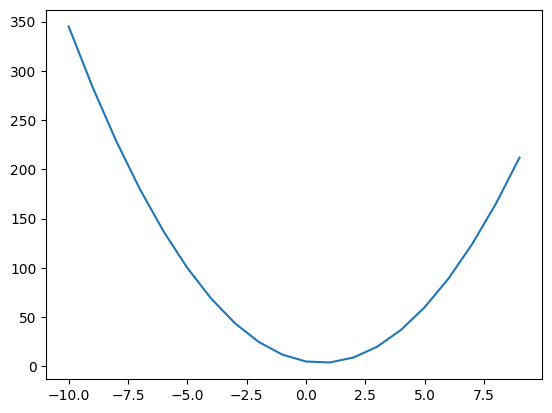

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10, 10, dtype=np.float32)
y = f(x)

plt.plot(x, y);

In [4]:
def finite_diff_deriv(f, c, h=1e-5):
    return (f(c + h) - f(c)) / h 

finite_diff_deriv(f, 3.0)

14.00003000000538

In [5]:
def f_sym_deriv(c):
    return (6 * c) - 4

f_sym_deriv(3.0) 

14.0

# Gradients

In [6]:
def g(a, b, c):
    return (a * b) + c

g(2.0, -3.0, 10.0)

4.0

In [7]:
def finite_diff_gradient(f, cs: tuple[float], h=1e-5):
    f_cs = f(*cs)

    gradient = []
    for i in range(len(cs)):
        new_vals = list(cs)
        new_vals[i] += h
        partial_deriv = (f(*new_vals) - f_cs) / h
        gradient.append(partial_deriv)
    return gradient

finite_diff_gradient(g, (2.0, -3.0, 10.0))

[-3.000000000064062, 2.0000000000131024, 0.9999999999621422]

# Value, graph, and manual gradients

In [8]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), _op="+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), _op="*")
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        return Value(t, (self,), _op="tanh")

In [9]:
from graphviz import Digraph

def draw_graph(v, graph=None, parent=None):
    if not graph:
        graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    uid = str(id(v))
    graph.node(name=uid, label=f"{v.label} | data {v.data:.4f} | grad {v.grad:.4f}", shape="record")

    if parent:
        graph.edge(uid, parent)

    if v._op:
        op_uid = uid+v._op
        graph.node(name=op_uid, label=v._op)
        graph.edge(op_uid, uid)
    
        for child in v._prev:
            draw_graph(child, graph, op_uid)

    return graph

Manual gradient: (6.0, -4.0, -2.0, 4.0)
Finite diff gradient: [6.000000000128124, -4.000000000026205, -1.9999999999242843, 4.000000000026205]


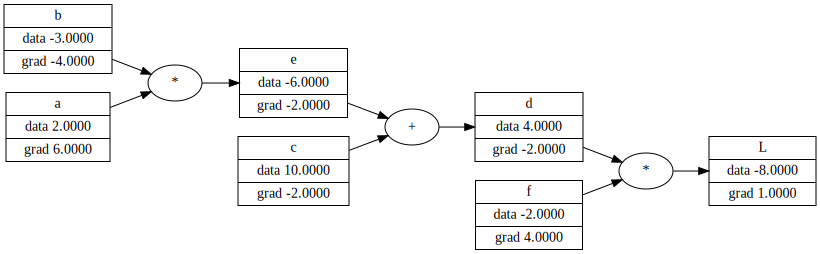

In [10]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label="e"
d = e + c; d.label="d"
f = Value(-2.0, label="f")
L = d * f; L.label="L"
L, L._prev, L._op

# Manual backprop.
L.grad = 1.0  # dL/dL = 1

d.grad = L.grad * f.data  # dL/dd = f
f.grad = L.grad * d.data  # dL/df = d

e.grad = d.grad * 1.0  # dL/de = dL/dd * dd/de
c.grad = d.grad * 1.0  # dL/dc = dL/dd * dd/dc

a.grad = e.grad * b.data  # dL/da = dL/de * de/da
b.grad = e.grad * a.data  # dL/db = dL/de * de/da

print(f"Manual gradient: {a.grad, b.grad, c.grad, f.grad}")

# Finite diff gradients.
def L_func(a, b, c, f):
    e = a * b
    d = e + c
    L = d * f
    return L

print(f"Finite diff gradient: {finite_diff_gradient(L_func, (2.0, -3.0, 10.0, -2.0))}")

draw_graph(L)

Manual gradient: (-1.4999999999999996, 0.9999999999999998, 0.4999999999999999, 0.0, 0.4999999999999999)
Finite diff gradient: [-1.5000318200564242, 0.9999858579412545, 0.4999964644536447, 0.0, 0.4999964644536447]


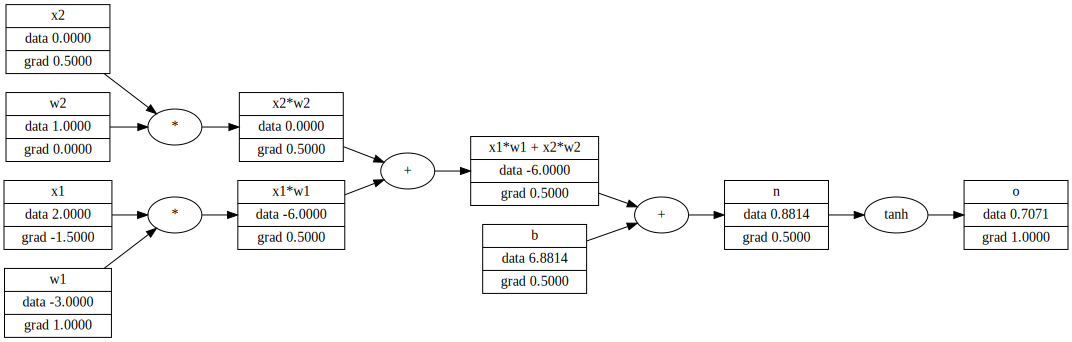

In [11]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

o = n.tanh(); o.label="o"

# Manual backprop.
o.grad = 1.0

n.grad = o.grad * (1.0 - (o.data ** 2.0))  # d tanh(x) / dx = 1 - (tanh(x) ** 2)

b.grad = n.grad * 1.0
x1w1_x2w2.grad = n.grad * 1.0

x1w1.grad = x1w1_x2w2.grad * 1.0
x2w2.grad = x1w1_x2w2.grad * 1.0

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data

print(f"Manual gradient: {x1.grad, w1.grad, x2.grad, w2.grad, b.grad}")

# Finite diff gradients.
def o_func(x1, w1, x2, w2, b):
    x1w1 = x1 * w1
    x2w2 = x2 * w2
    x1w1_x2w2 = x1w1 + x2w2
    n = x1w1_x2w2 + b
    o = (math.exp(2.0 * n) - 1) / (math.exp(2.0 * n) + 1)
    return o

print(f"Finite diff gradient: {finite_diff_gradient(o_func, (x1.data, w1.data, x2.data, w2.data, b.data))}")

draw_graph(o)

# Autograd w/ Value

In [12]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), _op="*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), _op="tanh")
        
        def _backward():
            self.grad = (1 - (t ** 2.0)) * out.grad
        out._backward = _backward

        return out

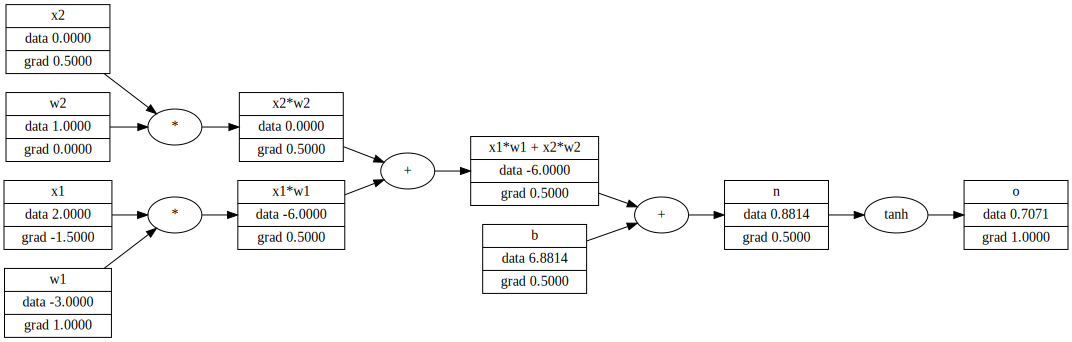

In [13]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

o = n.tanh(); o.label="o"

# Call ._backward() manually.
o.grad = 1.0
o._backward()

n._backward()

b._backward()
x1w1_x2w2._backward()

x1w1._backward()
x2w2._backward()

x1._backward()
w1._backward()

x2._backward()
w2._backward()

draw_graph(o)

[Value(data=6.881373587019543), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=-6.0), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


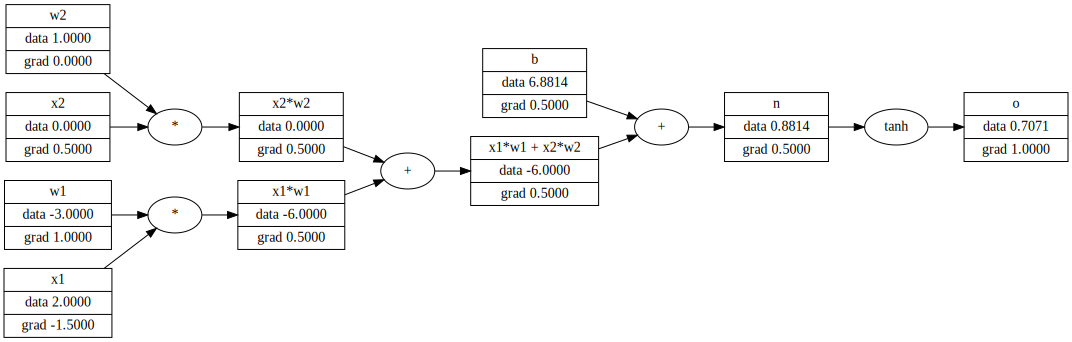

In [14]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

o = n.tanh(); o.label="o"

# Call ._backward() topologically.
# We can only call _backward() on a node when everything after is has been called ._backward() on so that its derivative is fully updated.
# We need to build a topological map of the graph. Collect all children nodes, then add itself. This builds a list where the root node is at the end.
# Each node is appended after all of its children. So, each upstream node must be called ._backward() on before this node.
topo = []
visited = set()
def build_topo(v):
    if v in visited: return

    visited.add(v)
    for child in v._prev:
        build_topo(child)

    topo.append(v)

build_topo(o)
print(topo)

o.grad = 1.0
for v in reversed(topo):
    v._backward()

draw_graph(o)

In [15]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v in visited: return

            visited.add(v)
            for child in v._prev:
                build_topo(child)

            topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), _op="*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), _op="tanh")
        
        def _backward():
            self.grad = (1 - (t ** 2.0)) * out.grad
        out._backward = _backward

        return out

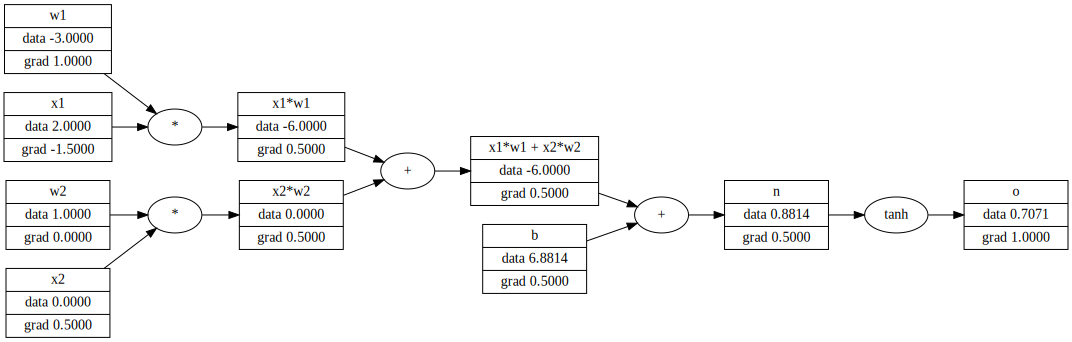

In [16]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

o = n.tanh(); o.label="o"

# Call .backward()
o.backward()

draw_graph(o)

# Backprop bug

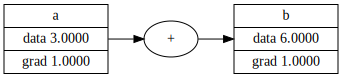

In [17]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()

# The issue is that after we topo sort and call b._backward(), a performs the following:
# def _backward():
#     self.grad = 1.0 * out.grad
#     other.grad = 1.0 * out.grad
# Unfortunatly, since self and other are the same (a + a), the grads overwrite each other. Instead, use +=.

draw_graph(b)

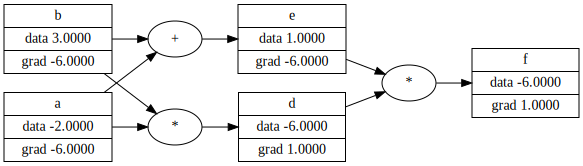

In [18]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label="d"
e = a + b; e.label="e"
f = d * e; f.label="f"

f.backward()

# Similar issue here (any time we use a variable more than once).
# After topo sort, f, d, and e grads will be calculated.
# d._backward() will distribute gradient to a and b, but then e._backward() will overwrite the gradients instead of adding.
# Use self.grad += ..., accumulate gradient instead of adding.
# Multivariable chain rule: dz_dt = dz_dx * dx_dt + dz_dy + dy_dt.

draw_graph(f)

In [19]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v in visited: return

            visited.add(v)
            for child in v._prev:
                build_topo(child)

            topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), _op="tanh")
        
        def _backward():
            self.grad += (1 - (t ** 2.0)) * out.grad
        out._backward = _backward

        return out

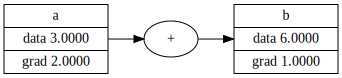

In [20]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()
draw_graph(b)

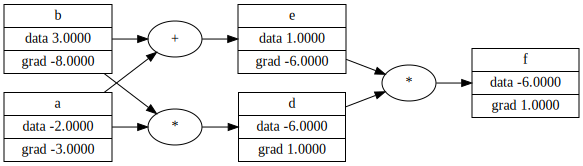

In [21]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label="d"
e = a + b; e.label="e"
f = d * e; f.label="f"

f.backward()

draw_graph(f)

# Break up tanh + more ops

In [22]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v in visited: return

            visited.add(v)
            for child in v._prev:
                build_topo(child)

            topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def _force_value(self, other: float | Value) -> Value:
        return other if isinstance(other, Value) else Value(other)
    
    def __add__(self, other):
        other = self._force_value(other)
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        """other + self."""
        return self + other

    def __mul__(self, other):
        other = self._force_value(other)
        out = Value(self.data * other.data, (self, other), _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        """other * self."""
        return self * other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "Only supports Value ** scalar."
        out = Value(self.data ** other, (self,), _op="**")

        def _backward():
            self.grad += other * (self.data ** (other - 1.0)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * (other ** -1.0)
    
    def exp(self):
        e_x = math.exp(self.data)
        out = Value(e_x, (self,), _op="exp")

        def _backward():
            self.grad += e_x * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), _op="tanh")
        
        def _backward():
            self.grad += (1 - (t ** 2.0)) * out.grad
        out._backward = _backward

        return out

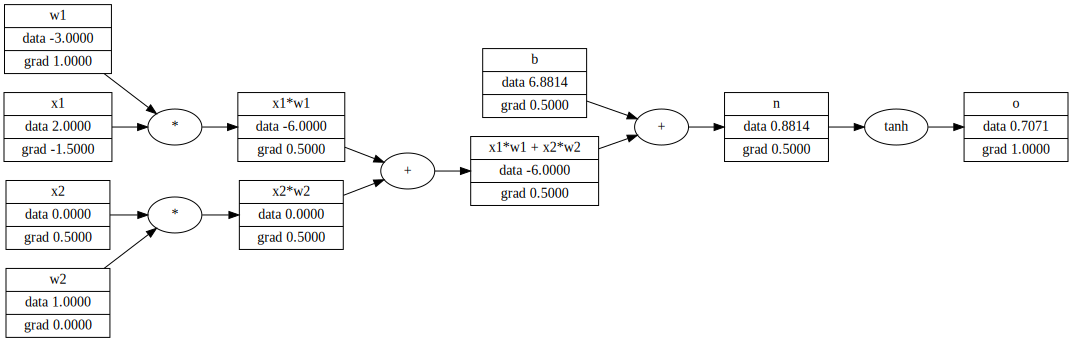

In [23]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

o = n.tanh(); o.label="o"

# Call .backward()
o.backward()

draw_graph(o)

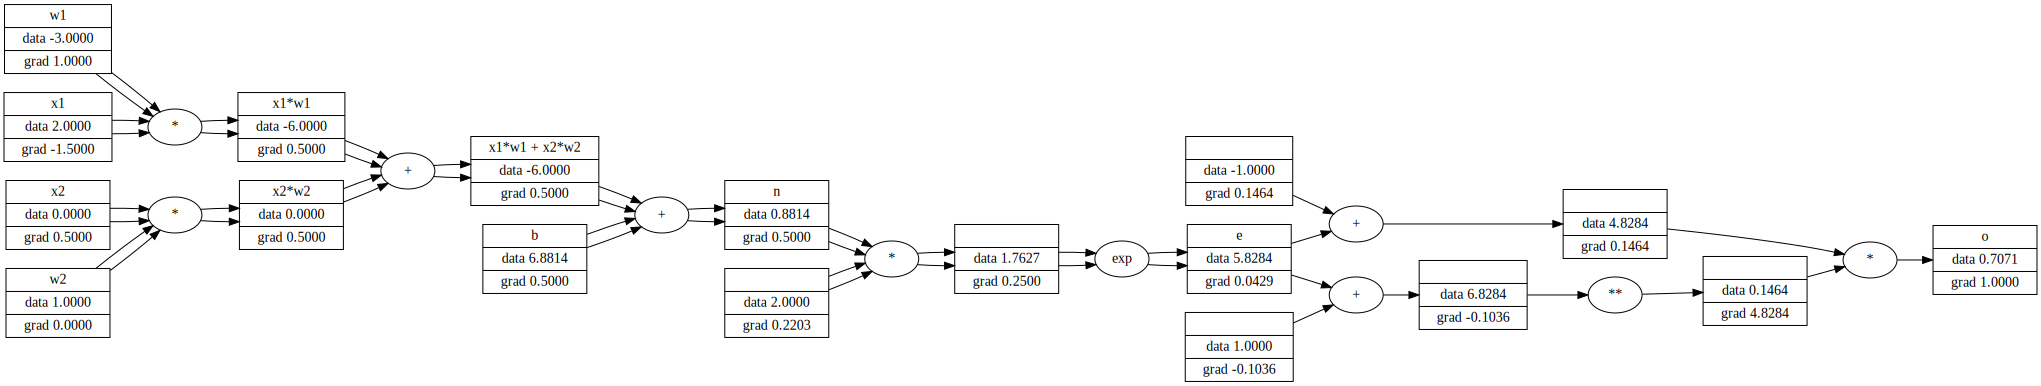

In [24]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

e = (2.0 * n).exp(); e.label="e"
o = (e - 1) / (e + 1); o.label="o"

# Call .backward()
o.backward()

draw_graph(o)

# Here we get ugly duplicate lines. This happens because we use e twice, so children of e are drawn twice.

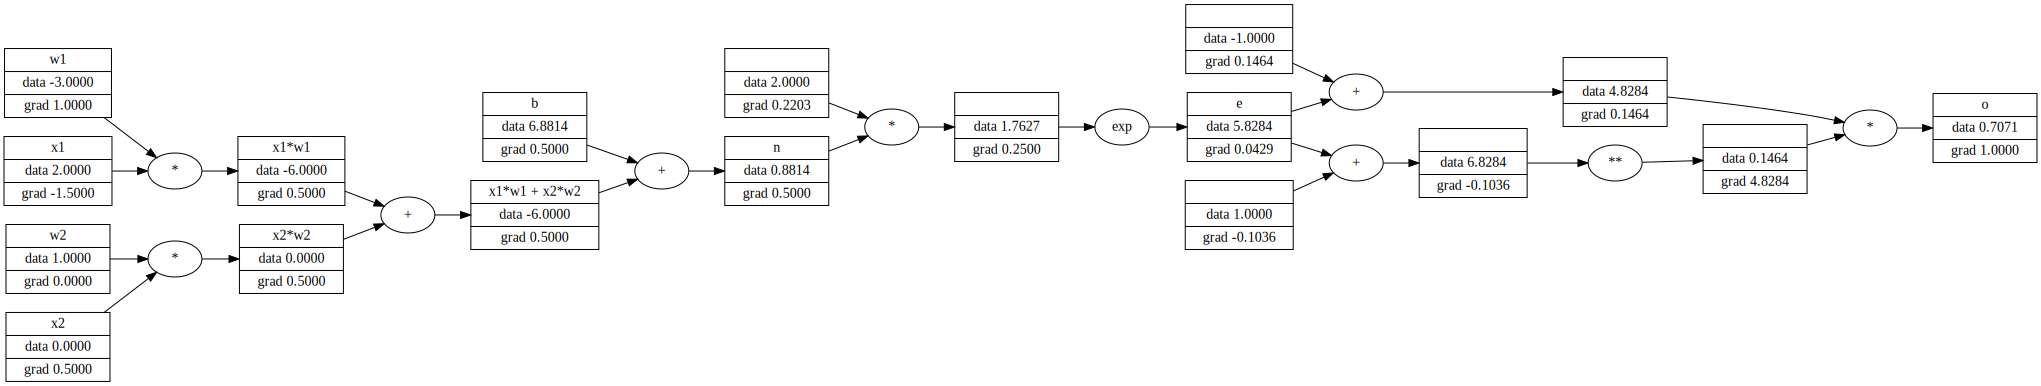

In [25]:
from graphviz import Digraph

def draw_graph(v, graph=None, visited=None):
    if not graph:
        graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    if not visited:
        visited = set()
    
    if v in visited:
        return
    visited.add(v)

    uid = str(id(v))
    graph.node(name=uid, label=f"{v.label} | data {v.data:.4f} | grad {v.grad:.4f}", shape="record")

    if v._op:
        op_uid = uid+v._op
        graph.node(name=op_uid, label=v._op)
        graph.edge(op_uid, uid)
    
        for child in v._prev:
            graph.edge(str(id(child)), op_uid)  # This is kinda hacky since we get the uid of the child before the child node is even drawn or processed.
            draw_graph(child, graph, visited)

    return graph

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label="x1*w1 + x2*w2"
n = x1w1_x2w2 + b; n.label="n"

e = (2.0 * n).exp(); e.label="e"
o = (e - 1) / (e + 1); o.label="o"

# Call .backward()
o.backward()

draw_graph(o)

# PyTorch

In [26]:
import torch

x1 = torch.tensor([2.0], requires_grad=True)
x2 = torch.tensor([0.0], requires_grad=True)

w1 = torch.tensor([-3.0], requires_grad=True)
w2 = torch.tensor([1.0], requires_grad=True)

b = torch.tensor([6.8813735870195432], requires_grad=True)

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1_x2w2 = x1w1 + x2w2
n = x1w1_x2w2 + b

o = n.tanh()

o.backward()

o, x1.grad, w1.grad, x2.grad, w2.grad, b.grad

(tensor([0.7071], grad_fn=<TanhBackward0>),
 tensor([-1.5000]),
 tensor([1.0000]),
 tensor([0.5000]),
 tensor([0.]),
 tensor([0.5000]))

# Neural Net with Micrograd

In [27]:
import random

class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for i in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, xs):
        act = sum(wi*xi for (wi, xi) in zip(self.w, xs)) + self.b
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for i in range(n_out)]

    def __call__(self, xs):
        return [n(xs) for n in self.neurons]
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, n_in, n_outs):
        ns = [n_in] + n_outs
        self.layers = [Layer(ns[i], ns[i+1]) for i in range(len(ns) - 1)]

    def __call__(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [28]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]  # targets.

def optim_step(mlp, lr):
    for p in mlp.parameters():
        p.data -= lr * p.grad

def zero_grad(mlp):
    for p in mlp.parameters():
        p.grad = 0.0

mlp = MLP(3, [4, 4, 1])

lr = 0.1
steps = 100
for i in range(steps):
    y_preds = [mlp(x) for x in xs]
    loss = sum((y_pred[0] - y) ** 2.0 for (y_pred, y) in zip(y_preds, ys)) / len(y_preds)

    zero_grad(mlp)
    loss.backward()
    optim_step(mlp, lr)
    
    if ((i % 10) == 0) or (i == (steps - 1)):
        print(f"Step {i}: loss={loss.data}")

print(y_preds)

Step 0: loss=2.320687121182667
Step 10: loss=0.8354455635350507
Step 20: loss=0.6949840180518996
Step 30: loss=0.5492435045698906
Step 40: loss=0.16918874171839196
Step 50: loss=0.050037323370656
Step 60: loss=0.02553152791467754
Step 70: loss=0.016479829383108928
Step 80: loss=0.01196655842989097
Step 90: loss=0.009312431903306268
Step 99: loss=0.007727374139773105
[[Value(data=0.9151733331236525)], [Value(data=-0.967236840818768)], [Value(data=-0.8786551244555404)], [Value(data=0.9110284892490498)]]


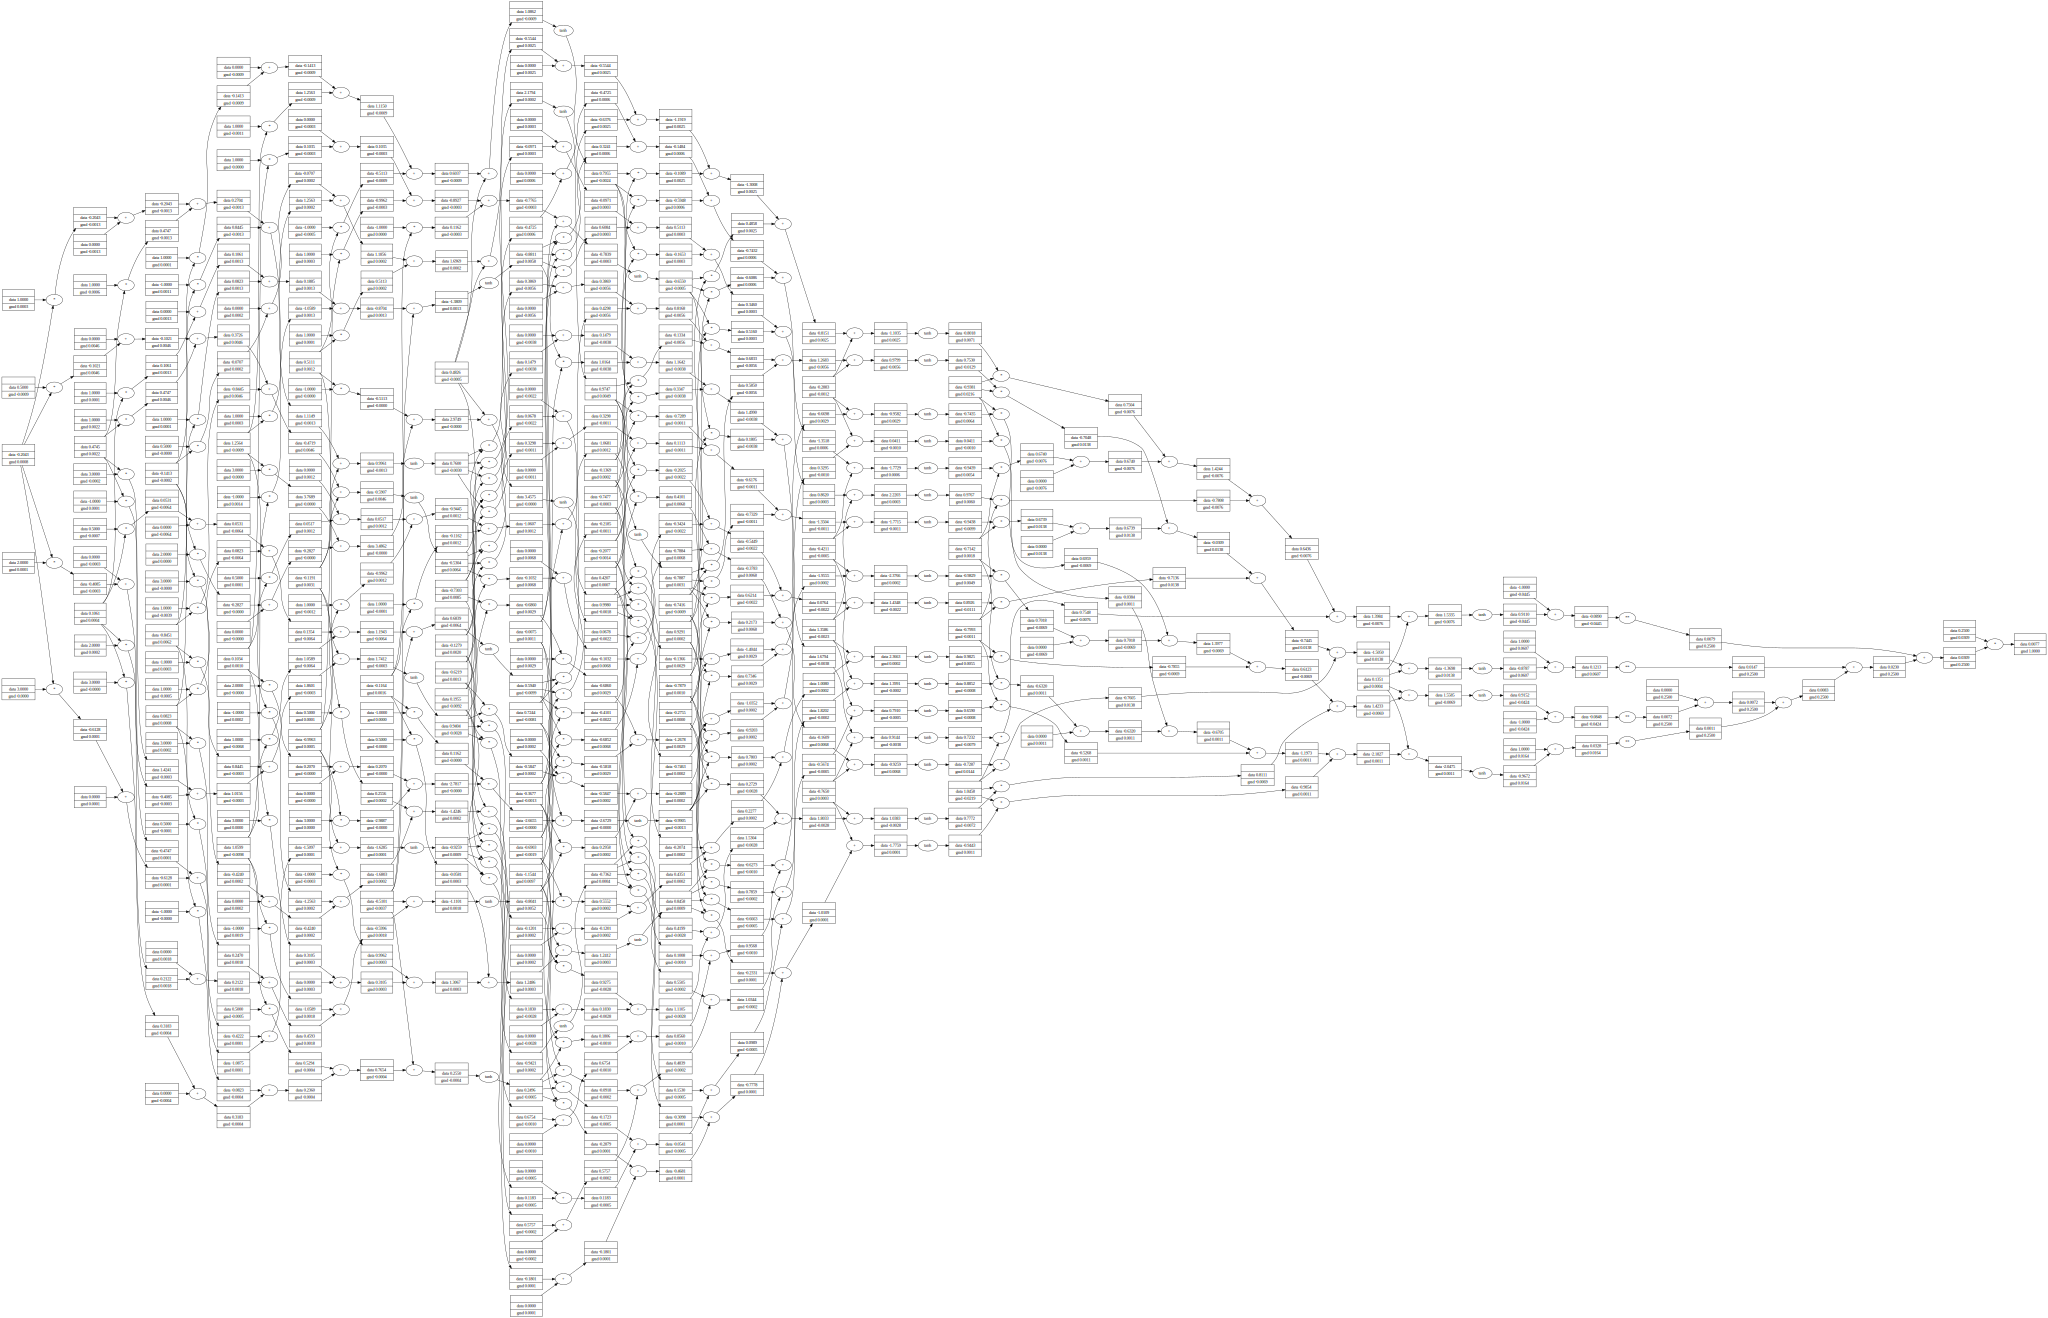

In [29]:
draw_graph(loss)

# [Defining a new PyTorch autograd function](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)

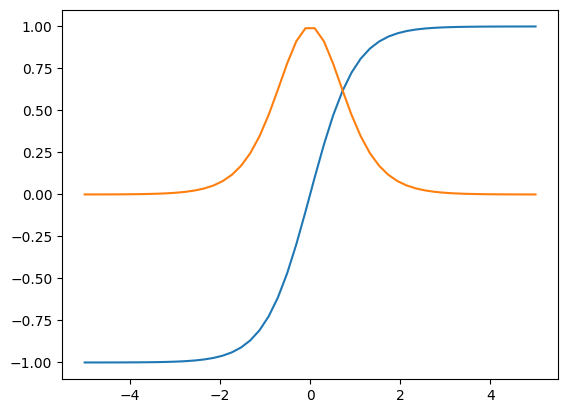

In [30]:
class MyTanh(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        e_2x = (2.0 * x).exp()
        tanh = (e_2x - 1.0) / (e_2x + 1.0)
        ctx.save_for_backward(tanh)
        return tanh
    
    @staticmethod
    def backward(ctx, grad_output):
        tanh, = ctx.saved_tensors
        return (1.0 - (tanh ** 2.0)) * grad_output
    
xs = torch.linspace(-5, 5, steps=50, requires_grad=True)
ys = MyTanh.apply(xs)
ys.sum().backward()

plt.plot(xs.detach().numpy(), ys.detach().numpy())
plt.plot(xs.detach().numpy(), xs.grad);

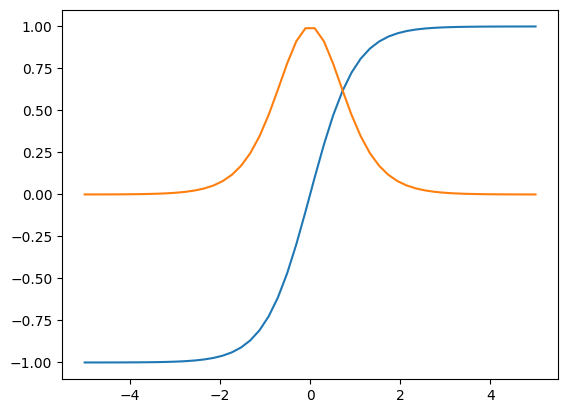

In [31]:
xs = torch.linspace(-5, 5, steps=50, requires_grad=True)
ys = xs.tanh()
ys.sum().backward()

plt.plot(xs.detach().numpy(), ys.detach().numpy())
plt.plot(xs.detach().numpy(), xs.grad);